In [1]:
# %matplotlib notebook
import matplotlib.pyplot as plt
from scipy import linalg
import scipy.io as sio
import pprint as pp
import numpy as np
import seaborn as sns
import pandas as pd
import os
import re
import gc
# pre
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer
# Study
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
import matplotlib as mpl
import numpy as np
import itertools
from mpl_toolkits.mplot3d import Axes3D
from time import time

# helpers files
import infoStructure as ins
import helpers as hp
import display as dp
import clustering as cl
import importlib #importlib.reload(foo)

In [2]:
SMLDDir = '/sanssauvegarde/homes/v18porti/info/Brest_Samples/'
BIGDDir = '/media/v18porti/ADATA SH14/stg/Brest/'
MDIR = BIGDDir

### Get LABELS

In [3]:
labels = ins.getFirstOneInfo(MDIR + 'RS10001/RS10001_170503_100212.mat')

### Get features info

In [4]:
t0 = time()
feat_dict = ins.addAllPatientsInfoV2(MDIR, ['vectorRRKLD', 'vectorFAmpKLD', 'vectorUFAmpKLD', 'vectorCorrKLD'], 20)
print("total time:", round(time()-t0, 3), "s")

Working on RS10000
Working on RS10001
Working on RS10002
Working on RS10003
Working on RS10004
Working on RS10005
Working on RS10006
Working on RS10007
Working on RS10008
Working on RS10009
Working on RS10010
Working on RS10012
Working on RS10013
Working on RS10014
Working on RS10015
Working on RS10016
Working on RS10017
Working on RS10018
Working on RS10019
total time: 118.386 s


In [5]:
vectorRRKLD_ALL = feat_dict['vectorRRKLD']
vectorFAmpKLD_ALL = feat_dict['vectorFAmpKLD']
vectorUFAmpKLD_ALL = feat_dict['vectorUFAmpKLD']
vectorCorrKLD_ALL = feat_dict['vectorCorrKLD']
del feat_dict
gc.collect()

0

In [6]:
print(vectorRRKLD_ALL.shape)
print(vectorFAmpKLD_ALL.shape)
print(vectorUFAmpKLD_ALL.shape)
print(vectorCorrKLD_ALL.shape)

(3031282,)
(3031282,)
(3031282,)
(3031282,)


### Tranform to a dataframe to be able to work better with it

In [7]:
df_ALL = hp.convertDictInDF(hp.putDataInDict(
        [vectorRRKLD_ALL, vectorFAmpKLD_ALL, vectorUFAmpKLD_ALL, vectorCorrKLD_ALL],
        ['vectorRRKLD_ALL', 'vectorFAmpKLD_ALL', 'vectorUFAmpKLD_ALL', 'vectorCorrKLD_ALL']
    ))

In [8]:
df_ALL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3031282 entries, 0 to 3031281
Data columns (total 4 columns):
vectorRRKLD_ALL       float64
vectorFAmpKLD_ALL     float64
vectorUFAmpKLD_ALL    float64
vectorCorrKLD_ALL     float64
dtypes: float64(4)
memory usage: 92.5 MB


In [9]:
df_ALL.describe()

,vectorRRKLD_ALL,vectorFAmpKLD_ALL,vectorUFAmpKLD_ALL,vectorCorrKLD_ALL
count,3.031215e+06,3.031282e+06,3.031282e+06,3.031282e+06
mean,7.019037e+05,6.140032e+01,7.237373e+01,8.585982e+00
std,6.110141e+08,3.456193e+02,3.851636e+02,9.308636e+00
min,-7.000370e-01,1.394684e+00,1.960751e+00,3.774464e-05
25%,7.699728e+00,4.084109e+00,9.402939e+00,3.657024e+00
50%,9.837840e+00,5.867058e+00,1.318947e+01,5.750543e+00
75%,1.469460e+01,9.428177e+00,2.254919e+01,9.896061e+00
max,5.349180e+11,7.853246e+03,1.405988e+04,4.482173e+02


In [10]:
df_ALL.corr()

,vectorRRKLD_ALL,vectorFAmpKLD_ALL,vectorUFAmpKLD_ALL,vectorCorrKLD_ALL
vectorRRKLD_ALL,1.000000,-0.000187,-0.000046,0.005341
vectorFAmpKLD_ALL,-0.000187,1.000000,0.975596,-0.007876
vectorUFAmpKLD_ALL,-0.000046,0.975596,1.000000,0.013317
vectorCorrKLD_ALL,0.005341,-0.007876,0.013317,1.000000


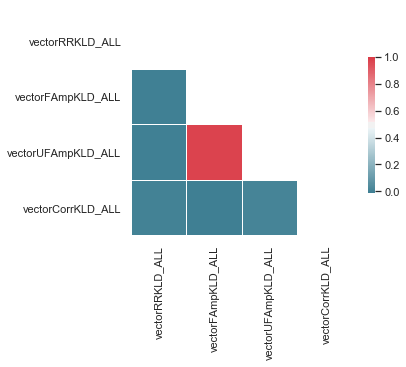

In [11]:
%matplotlib inline
dp.draw_correlation_matrix(df_ALL)

/homes/v18porti/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/homes/v18porti/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


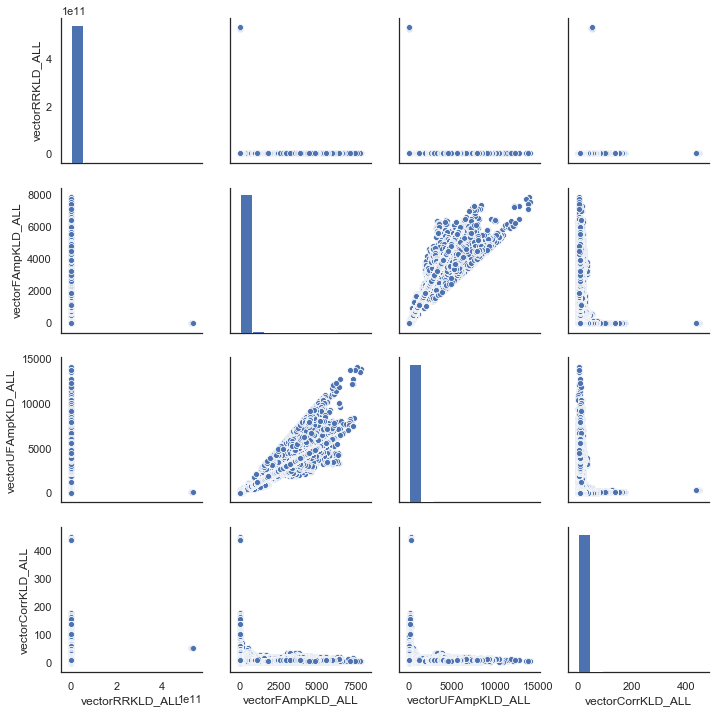

In [12]:
sns.pairplot(df_ALL)

In [ ]:
#sns.jointplot(df_ALL['vectorFAmpKLD_ALL'], df_ALL['vectorRRKLD_ALL'], kind="kde")

## Outliers

In [93]:
len(df_ALL) - df_ALL.count()

vectorRRKLD_ALL       67
vectorFAmpKLD_ALL      0
vectorUFAmpKLD_ALL     0
vectorCorrKLD_ALL      0
dtype: int64

In [103]:
num_attribs = list(df_ALL)

pipeline = Pipeline([
        ('selector', hp.DataFrameSelector(num_attribs)), # to handle pandas data frame
        ('imputer', Imputer(strategy="median")), # fill missing values with median
    ])

data_prepared = pipeline.fit_transform(df_ALL)

3031282

In [104]:
df_prepare = hp.convertDictInDF(hp.putDataInDict(
        [data_prepared[:,0], data_prepared[:,1], data_prepared[:,2], data_prepared[:,3]],
        ['vectorRRKLD_N', 'vectorFAmpKLD_N', 'vectorUFAmpKLD_N', 'vectorCorrKLD_N']
    ))
df_prepare.describe()

,vectorRRKLD_N,vectorFAmpKLD_N,vectorUFAmpKLD_N,vectorCorrKLD_N
count,3.031282e+06,3.031282e+06,3.031282e+06,3.031282e+06
mean,7.018882e+05,6.140032e+01,7.237373e+01,8.585982e+00
std,6.110073e+08,3.456193e+02,3.851636e+02,9.308636e+00
min,-7.000370e-01,1.394684e+00,1.960751e+00,3.774464e-05
25%,7.699792e+00,4.084109e+00,9.402939e+00,3.657024e+00
50%,9.837840e+00,5.867058e+00,1.318947e+01,5.750543e+00
75%,1.469450e+01,9.428177e+00,2.254919e+01,9.896061e+00
max,5.349180e+11,7.853246e+03,1.405988e+04,4.482173e+02


In [108]:
X = data_prepare
len(X)

3031282

In [109]:

Y_, km = cl.getKmeanskClusters(2, X)

In [110]:
titles = df_prepare.columns.tolist()

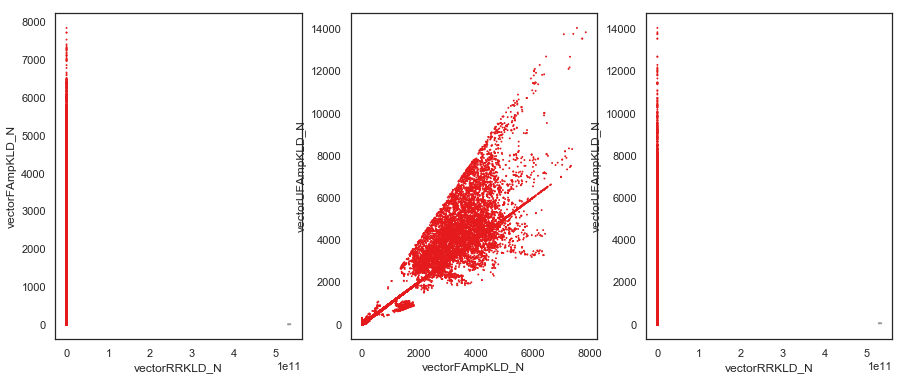

{'>50': 1, '>30': 0, '>15': 0, '<15': 1}
[{'group': 0, 'qty': 3031278, 'representativeness': 0.9999986804263015}, {'group': 1, 'qty': 4, 'representativeness': 1.3195736985209559e-06}]


In [40]:
print(hp.getRepresentativenessKM(km, X, Y_))

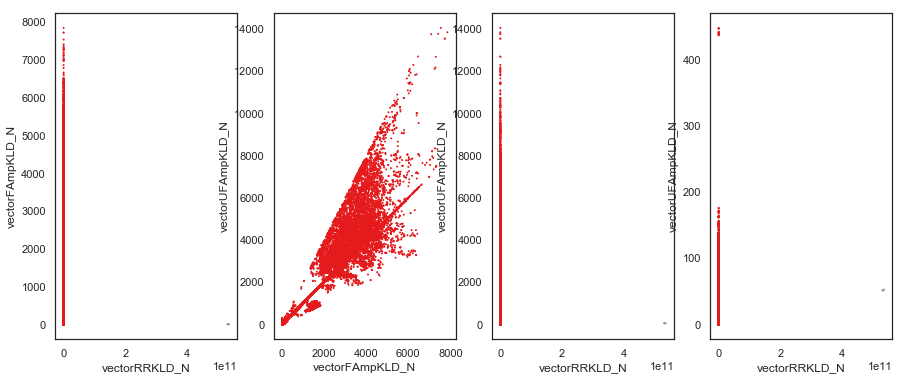

In [78]:
fig, ax = plt.subplots(1, 4, figsize=(15, 6))
ax[0].scatter(X[:, 0], X[:, 1], c=Y_, s=0.9, cmap='Set1')
ax[0].set_xlabel(titles[0])
ax[0].set_ylabel(titles[1])
ax[1].scatter(X[:, 1], X[:, 2], c=Y_, s=0.9, cmap='Set1')
ax[1].set_xlabel(titles[1])
ax[1].set_ylabel(titles[2])
ax[2].scatter(X[:, 0], X[:, 2], c=Y_, s=0.9, cmap='Set1')
ax[2].set_xlabel(titles[0])
ax[2].set_ylabel(titles[2])
ax[3].scatter(X[:, 0], X[:, 3], c=Y_, s=0.9, cmap='Set1')
ax[3].set_xlabel(titles[0])
ax[3].set_ylabel(titles[2])
plt.show()
plt.close()

In [45]:
ex =  np.arange(16).reshape(4, 4)
ex

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [49]:
a_del = np.delete(ex, 3, 0)
a_del

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [63]:
np.arange(9.).reshape(3, 3)

array([[0., 1., 2.],
       [3., 4., 5.],
       [6., 7., 8.]])

In [62]:
np.where(Y_ == 1)

(array([203065, 203066, 203067, 203068]),)

In [111]:
def getSmallerGroup(r):
    s = { 'group': -1, 'qty': 1000}
    for i, e in enumerate(r):
        if e['qty'] < s['qty']: s = e
    return s

representativeness = hp.getRepresentativenessKM(km, X, Y_)
group = getSmallerGroup(representativeness)

{'>50': 1, '>30': 0, '>15': 0, '<15': 1}


In [112]:
def delOutlier(X, Y_, group) :
    todel = np.where(Y_ == group)
    print(todel)
    new_X = X[:]
    new_Y = Y_[:]
    for i, row in enumerate(todel):
        new_X = np.delete(new_X, row, 0)
        new_Y = np.delete(new_Y, row, 0)
    return new_X, new_Y

X = data_prepare
new_X, new_Y = delOutlier(X, Y_, group['group'])
print(len(new_X))
print(len(new_Y))

(array([203065, 203066, 203067, 203068]),)
3031278
3031278


In [113]:
df_prepare = hp.convertDictInDF(hp.putDataInDict(
        [new_X[:,0], new_X[:,1], new_X[:,2], new_X[:,3]],
        ['vectorRRKLD_N', 'vectorFAmpKLD_N', 'vectorUFAmpKLD_N', 'vectorCorrKLD_N']
    ))
df_prepare.describe()

,vectorRRKLD_N,vectorFAmpKLD_N,vectorUFAmpKLD_N,vectorCorrKLD_N
count,3.031278e+06,3.031278e+06,3.031278e+06,3.031278e+06
mean,1.251674e+01,6.140040e+01,7.237375e+01,8.585925e+00
std,2.724741e+01,3.456195e+02,3.851638e+02,9.308509e+00
min,-7.000370e-01,1.394684e+00,1.960751e+00,3.774464e-05
25%,7.699785e+00,4.084109e+00,9.402935e+00,3.657017e+00
50%,9.837840e+00,5.867069e+00,1.318946e+01,5.750538e+00
75%,1.469446e+01,9.428183e+00,2.254912e+01,9.896046e+00
max,2.531410e+04,7.853246e+03,1.405988e+04,4.482173e+02


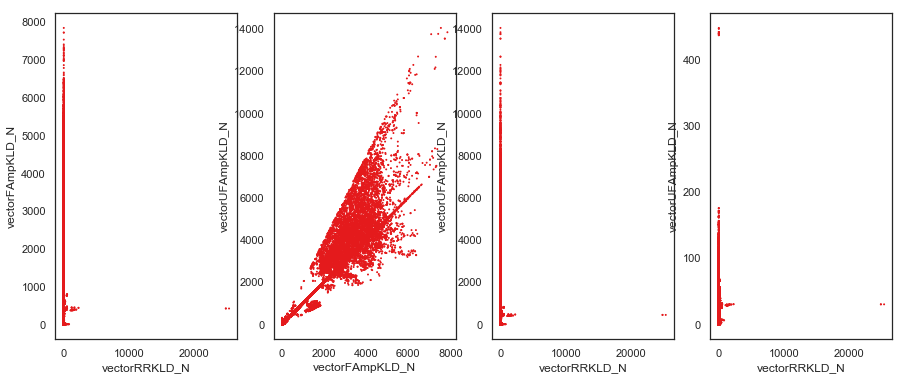

In [114]:
X = new_X
Y_ = new_Y
fig, ax = plt.subplots(1, 4, figsize=(15, 6))
ax[0].scatter(X[:, 0], X[:, 1], c=Y_, s=0.9, cmap='Set1')
ax[0].set_xlabel(titles[0])
ax[0].set_ylabel(titles[1])
ax[1].scatter(X[:, 1], X[:, 2], c=Y_, s=0.9, cmap='Set1')
ax[1].set_xlabel(titles[1])
ax[1].set_ylabel(titles[2])
ax[2].scatter(X[:, 0], X[:, 2], c=Y_, s=0.9, cmap='Set1')
ax[2].set_xlabel(titles[0])
ax[2].set_ylabel(titles[2])
ax[3].scatter(X[:, 0], X[:, 3], c=Y_, s=0.9, cmap='Set1')
ax[3].set_xlabel(titles[0])
ax[3].set_ylabel(titles[2])
plt.show()
plt.close()

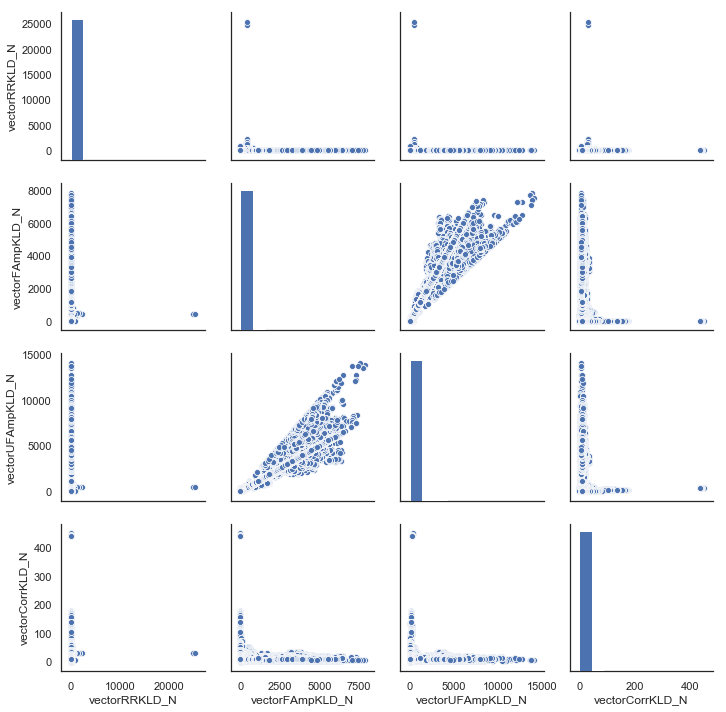

In [115]:
sns.pairplot(df_prepare)

In [129]:
from sklearn.cluster import DBSCAN

In [116]:
representativeness = hp.getRepresentativenessKM(km, X, Y_)
representativeness

{'>50': 1, '>30': 0, '>15': 0, '<15': 1}


[{'group': 0, 'qty': 3031278, 'representativeness': 1.0},
 {'group': 1, 'qty': 0, 'representativeness': 0.0}]

In [ ]:
clustering = DBSCAN(eps=3, min_samples=2).fit(X)

{'>50': 1, '>30': 0, '>15': 0, '<15': 1}
[{'group': 0, 'qty': 2607489, 'representativeness': 0.8601946109858614}, {'group': 1, 'qty': 423789, 'representativeness': 0.13980538901413858}]


ValueError: expected square matrix

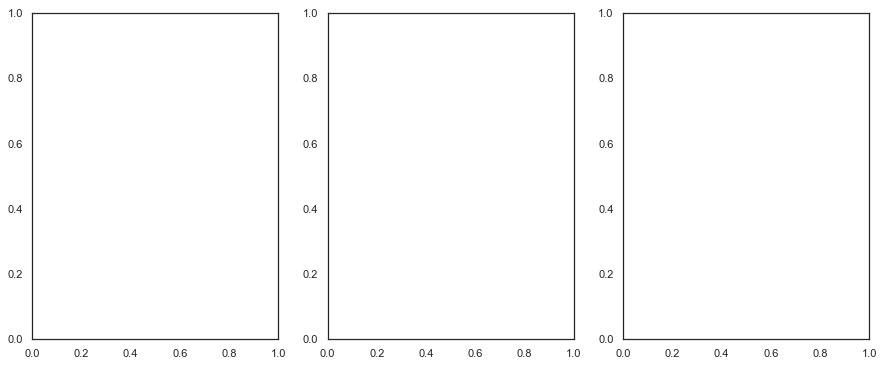

In [126]:
Y_ = clustering.labels_
print(hp.getRepresentativeness(dpgmm1, X, Y_))
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
dp.plotGM(X, Y_, dpgmm1.means_, dpgmm1.covariances_, ax[0], 0, 1, color_iter)
dp.plotGM(X, Y_, dpgmm1.means_, dpgmm1.covariances_, ax[1], 1, 2, color_iter)
dp.plotGM(X, Y_, dpgmm1.means_, dpgmm1.covariances_, ax[2], 0, 2, color_iter)
plt.show()
fig.clf()
plt.close()

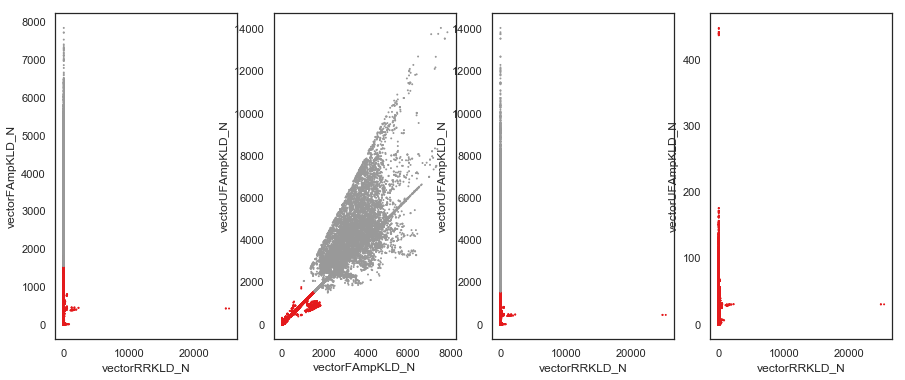

In [119]:
fig, ax = plt.subplots(1, 4, figsize=(15, 6))
ax[0].scatter(X[:, 0], X[:, 1], c=Y_, s=0.9, cmap='Set1')
ax[0].set_xlabel(titles[0])
ax[0].set_ylabel(titles[1])
ax[1].scatter(X[:, 1], X[:, 2], c=Y_, s=0.9, cmap='Set1')
ax[1].set_xlabel(titles[1])
ax[1].set_ylabel(titles[2])
ax[2].scatter(X[:, 0], X[:, 2], c=Y_, s=0.9, cmap='Set1')
ax[2].set_xlabel(titles[0])
ax[2].set_ylabel(titles[2])
ax[3].scatter(X[:, 0], X[:, 3], c=Y_, s=0.9, cmap='Set1')
ax[3].set_xlabel(titles[0])
ax[3].set_ylabel(titles[2])
plt.show()
plt.close()

### Pre processing

In [13]:
len(df_ALL) - df_ALL.count()

vectorRRKLD_ALL       67
vectorFAmpKLD_ALL      0
vectorUFAmpKLD_ALL     0
vectorCorrKLD_ALL      0
dtype: int64

In [14]:
num_attribs = list(df_ALL)

pipeline = Pipeline([
        ('selector', hp.DataFrameSelector(num_attribs)), # to handle pandas data frame
        ('imputer', Imputer(strategy="median")), # fill missing values with median
        ('std_scaler', StandardScaler())
    ])

full_pipeline = FeatureUnion(transformer_list=[
    ("main", pipeline),
    ])

data_prepared = full_pipeline.fit_transform(df_ALL)

In [15]:
df_normalized = hp.convertDictInDF(hp.putDataInDict(
        [data_prepared[:,0], data_prepared[:,1], data_prepared[:,2], data_prepared[:,3]],
        ['vectorRRKLD_N', 'vectorFAmpKLD_N', 'vectorUFAmpKLD_N', 'vectorCorrKLD_N']
    ))
df_normalized.describe()

,vectorRRKLD_N,vectorFAmpKLD_N,vectorUFAmpKLD_N,vectorCorrKLD_N
count,3.031282e+06,3.031282e+06,3.031282e+06,3.031282e+06
mean,1.112391e-18,5.297516e-18,-1.366572e-17,-1.276092e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.148741e-03,-1.736178e-01,-1.828132e-01,-9.223634e-01
25%,-1.148727e-03,-1.658363e-01,-1.634911e-01,-5.295038e-01
50%,-1.148723e-03,-1.606776e-01,-1.536601e-01,-3.046031e-01
75%,-1.148716e-03,-1.503740e-01,-1.293595e-01,1.407381e-01
max,8.754681e+02,2.254459e+01,3.631577e+01,4.722834e+01


### PCA

>*[0.50219192 0.28210948 0.20605092 0.00964767]* : first 3 carries the most info with standarized data (95%)
>
>*[0.92169138 0.04827627 0.02278563 0.00724673]* : first 1 carries the most info without standarizing data
>
> This is how we know we should standarize since it permits the other 2 axes to participate

In [16]:
X = data_prepared

In [17]:
pca = PCA(n_components=0.95)
pca.fit(X)  
print(pca.explained_variance_ratio_) 
print(pca.singular_values_)
print(pca.components_)

[0.49390271 0.25136274 0.248691  ]
[2447.16847455 1745.79648557 1736.49364115]
[[-1.47678863e-04  7.07079867e-01  7.07122685e-01  3.94321914e-03]
 [ 6.99958563e-01 -9.68163168e-03  5.84513443e-03  7.14093908e-01]
 [ 7.14183441e-01  9.61693420e-03 -5.56442116e-03 -6.99870391e-01]]


In [18]:
X_New = pca.transform(X)
principalDf = pd.DataFrame(data=X_New, columns=['pc1', 'pc2', 'pc3'])

<IPython.core.display.Javascript object>


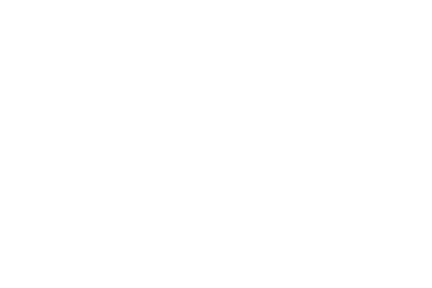

<IPython.core.display.Javascript object>


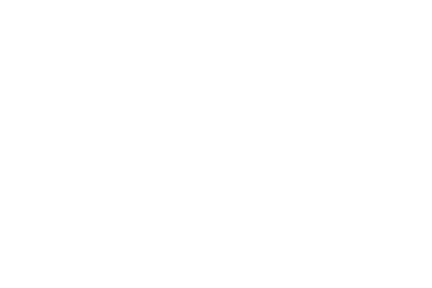

In [19]:
%matplotlib notebook
dp.print3dScatter(principalDf['pc1'], principalDf['pc2'], principalDf['pc3'])

<IPython.core.display.Javascript object>


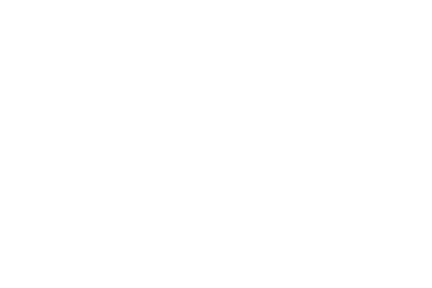

In [20]:
plt.clf()
plt.close()

In [21]:
%matplotlib inline

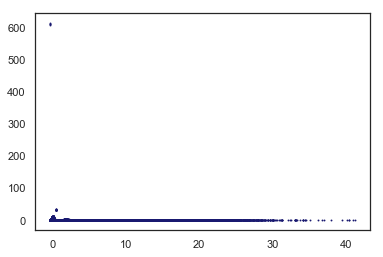

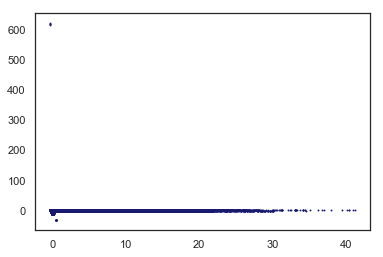

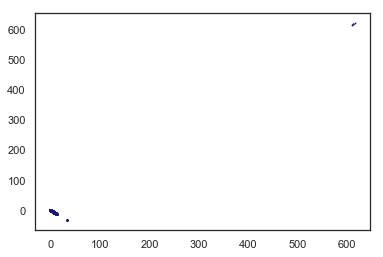

In [22]:
dp.printScatter(principalDf['pc1'], principalDf['pc2'])
dp.printScatter(principalDf['pc1'], principalDf['pc3'])
dp.printScatter(principalDf['pc2'], principalDf['pc3'])

In [23]:
titles = principalDf.columns.tolist()
principalDf.describe()

,pc1,pc2,pc3
count,3.031282e+06,3.031282e+06,3.031282e+06
mean,1.467365e-18,-4.865394e-17,2.092871e-17
std,1.405564e+00,1.002722e+00,9.973787e-01
min,-2.555171e-01,-6.590124e-01,-3.305960e+01
25%,-2.336353e-01,-3.790219e-01,-9.873375e-02
50%,-2.220097e-01,-2.182422e-01,2.122854e-01
75%,-1.958135e-01,9.915016e-02,3.698749e-01
max,4.124151e+01,6.161720e+02,6.219315e+02


## ------{ X to use }-----

In [24]:
X = X_New

## 1 Gaussian Mixture Model

https://scikit-learn.org/stable/unsupervised_learning.html


In [ ]:
importlib.reload(cl)
importlib.reload(dp)
importlib.reload(hp)

In [25]:
n_components_range = range(1, 7)
best_gmm, bic, cv_types = cl.getBestGMMUsingBIC(X, n_components_range)

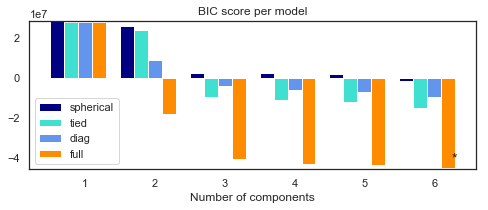

In [26]:
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange', 'gold', 'tomato'])
dp.plotBICScores(bic, cv_types, color_iter, n_components_range)

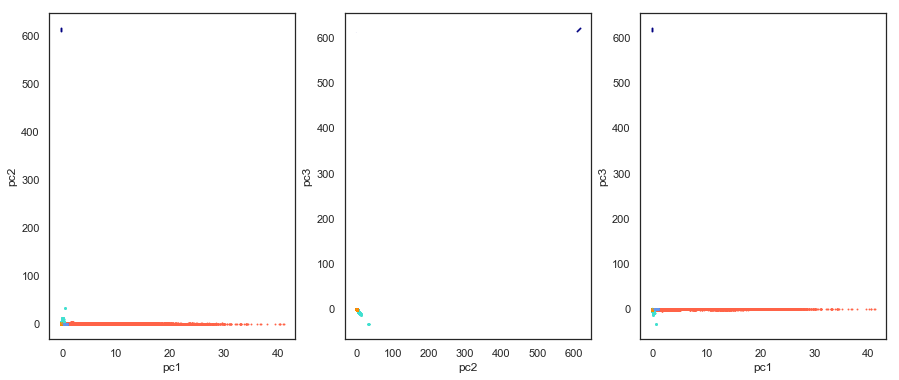

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
dp.getPlotGMM(best_gmm, X, color_iter, 0, 1, ax[0], titles)
dp.getPlotGMM(best_gmm, X, color_iter, 1, 2, ax[1], titles)
dp.getPlotGMM(best_gmm, X, color_iter, 0, 2, ax[2], titles)
plt.show()
fig.clf()
plt.close()

In [29]:
hp.getRepresentativeness(best_gmm, X, best_gmm.predict(X))

{'>50': 1, '>30': 0, '>15': 1, '<15': 4}


[{'group': 0, 'qty': 1785074, 'representativeness': 0.5888841750783992},
 {'group': 1, 'qty': 101085, 'representativeness': 0.033347276828747704},
 {'group': 2, 'qty': 4, 'representativeness': 1.3195736985209559e-06},
 {'group': 3, 'qty': 105692, 'representativeness': 0.03486709583601921},
 {'group': 4, 'qty': 157213, 'representativeness': 0.05186353496639376},
 {'group': 5, 'qty': 882214, 'representativeness': 0.2910365977167416}]

## 2 K-Means

[2, 3, 4, 5] components

In [ ]:
Y_, km = cl.getKmeanskClusters(2, X)
dp.printThreeKMaeans(X, Y_, titles)
print(hp.getRepresentativenessKM(km, X, Y_))
Y_, km = cl.getKmeanskClusters(3, X)
dp.printThreeKMaeans(X, Y_, titles)
print(hp.getRepresentativenessKM(km, X, Y_))
Y_, km = cl.getKmeanskClusters(4, X)
dp.printThreeKMaeans(X, Y_, titles)
print(hp.getRepresentativenessKM(km, X, Y_))
Y_, km = cl.getKmeanskClusters(5, X)
dp.printThreeKMaeans(X, Y_, titles)
print(hp.getRepresentativenessKM(km, X, Y_))

## 3 Mean Shift
https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

> Bandwidth is not very different with quantity of samples 50000 or 100000, so for ease of computation, we will use 50000.
> 
> Quantile, it increases  the value of the bandwith, 0.3, gets 1.76 with 7 components, 0.5, gets 2.26 with 4 components

In [ ]:
bandwidth = estimate_bandwidth(X, n_samples=50000, quantile=0.3)
bandwidth

In [ ]:
bandwidth2 = estimate_bandwidth(X, n_samples=50000, quantile=0.5)
bandwidth2

In [ ]:
bandwidth3 = estimate_bandwidth(X, n_samples=50000, quantile=0.7)
bandwidth3

In [ ]:
bandwidth4 = estimate_bandwidth(X, n_samples=50000, quantile=0.2)
bandwidth4

In [ ]:
ms, n_clusters_, cluster_centers, labels = cl.meanClustering(X, bandwidth)
print(hp.getRepresentativenessKM(ms, X, ms.predict(X)))
dp.plotMSh(X, ms, n_clusters_, cluster_centers, labels)

In [ ]:
ms1, n_clusters_1, cluster_centers1, labels1 = cl.meanClustering(X, bandwidth2)
print(hp.getRepresentativenessKM(ms1, X, ms1.predict(X)))
dp.plotMSh(X, ms1, n_clusters_1, cluster_centers1, labels1)

## 4 Variational Bayesian Gaussian Mixture

Having 5 components, changig the n_init, it has a better distribution in "representativeness" with a value of 2 and max_iter = 200

In [ ]:
dpgmm1 = BayesianGaussianMixture(n_components=5,
                                max_iter=200, n_init=2,
                                covariance_type='full').fit(X)
#print(dpgmm1.means_)
#print(dpgmm1.covariances_)
Y_ = dpgmm1.predict(X)
print(hp.getRepresentativeness(dpgmm1, X, Y_))
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
dp.plotGM(X, Y_, dpgmm1.means_, dpgmm1.covariances_, ax[0], 0, 1, color_iter)
dp.plotGM(X, Y_, dpgmm1.means_, dpgmm1.covariances_, ax[1], 1, 2, color_iter)
dp.plotGM(X, Y_, dpgmm1.means_, dpgmm1.covariances_, ax[2], 0, 2, color_iter)
plt.show()
fig.clf()
plt.close()

In [ ]:
dpgmm2 = BayesianGaussianMixture(n_components=5,
                                max_iter=100, n_init=2,
                                covariance_type='full').fit(X)
#print(dpgmm2.means_)
#print(dpgmm2.covariances_)
Y_ = dpgmm2.predict(X)
print(hp.getRepresentativeness(dpgmm2, X, Y_))
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
dp.plotGM(X, Y_, dpgmm2.means_, dpgmm2.covariances_, ax[0], 0, 1, color_iter)
dp.plotGM(X, Y_, dpgmm2.means_, dpgmm2.covariances_, ax[1], 1, 2, color_iter)
dp.plotGM(X, Y_, dpgmm2.means_, dpgmm2.covariances_, ax[2], 0, 2, color_iter)
plt.show()
fig.clf()
plt.close()

In [ ]:
dpgmm3 = BayesianGaussianMixture(n_components=5,
                                max_iter=200,
                                covariance_type='full').fit(X)
#print(dpgmm3.means_)
#print(dpgmm3.covariances_)
Y_ = dpgmm3.predict(X)
print(hp.getRepresentativeness(dpgmm3, X, Y_))
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
dp.plotGM(X, Y_, dpgmm3.means_, dpgmm3.covariances_, ax[0], 0, 1, color_iter)
dp.plotGM(X, Y_, dpgmm3.means_, dpgmm3.covariances_, ax[1], 1, 2, color_iter)
dp.plotGM(X, Y_, dpgmm3.means_, dpgmm3.covariances_, ax[2], 0, 2, color_iter)
plt.show()
fig.clf()
plt.close()

In [ ]:
dpgmm4 = BayesianGaussianMixture(n_components=5,
                                max_iter=100,
                                covariance_type='full').fit(X)
#print(dpgmm4.means_)
#print(dpgmm4.covariances_)
Y_ = dpgmm4.predict(X)
print(hp.getRepresentativeness(dpgmm4, X, Y_))
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
dp.plotGM(X, Y_, dpgmm4.means_, dpgmm4.covariances_, ax[0], 0, 1, color_iter)
dp.plotGM(X, Y_, dpgmm4.means_, dpgmm4.covariances_, ax[1], 1, 2, color_iter)
dp.plotGM(X, Y_, dpgmm4.means_, dpgmm4.covariances_, ax[2], 0, 2, color_iter)
plt.show()
fig.clf()
plt.close()